In [1]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy import signal
from scipy.signal import argrelextrema, medfilt
import time, os
from datetime import datetime

In [2]:
# Выбор порта данных с катушек
ports = serial.tools.list_ports.comports()
port = None
# print(ports)
for i, port in enumerate(ports):
    # print(f"{port}")
    print(f"Порт {i}: {port.device}")
    # print(f"Описание: {port.description}")
    # print(f"VID:PID: {port.vid}:{port.pid}")
if port:
    # prt = int(input('Какой порт?'))
    port = ports[0].device
    port_motor = ports[1].device
    print(f'Для получения данных выбран порт - {port}')
    print(f'Для двигателя выбран порт - {port_motor}')

Порт 0: COM4
Порт 1: COM3
Порт 2: COM1
Для получения данных выбран порт - COM4
Для двигателя выбран порт - COM3


In [ ]:
# Отправка команды на вращение магнита
with (serial.Serial(port_motor, baudrate=57600, bytesize=8, parity='N', stopbits=1, timeout=0)) as serialData:
    # Read data from COM port
    revolutions = 22
    distance=1000/9
    speed=100
    command = f'ON\rMOVE L(-{int(revolutions * distance)})F({int(speed)})\rOFF\r'
    serialData.write(command.encode(encoding="utf-8"))

# Чтение данных с катушек в память контроллера
time.sleep(2)
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=11)) as serialData:
    # Read data from COM port
    command = 'R'

    # Send the command to the DataPort
    serialData.write(command.encode(encoding="utf-8"))
    # serialline.flush()
time.sleep(11)

# Получение данных с выбранного порта в память компьютера
rawdata = None
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=47)) as serialData:
    # Read data from COM port
    command = 'S'

    # Send the command to the DataPort
    serialData.write(command.encode())
    
    # Get data
    rawdata = serialData.read(4194305)

In [ ]:
# Перевод данных из битов в целые числа
data = []
for num in range(0, 2097152, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    data.append(hi_byte*256+lo_byte)

encoder = []
for num in range(2097152, len(rawdata)-1, 2):
    hi_byte = rawdata[num]
    hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
    lo_byte = rawdata[num+1]    
    encoder.append(hi_byte*256+lo_byte)
df_raw = pd.DataFrame({'encoder' : encoder, 'data' : data})


# Фильтрация данных от дельта-шумов
window_size = 3
df_filtered = pd.DataFrame(columns=['data', 'encoder'])
df_filtered.data = medfilt(df_raw.data, kernel_size=window_size)[window_size*2:-window_size*2]
df_filtered.encoder = medfilt(df_raw.encoder, kernel_size=window_size)[window_size*2:-window_size*2]

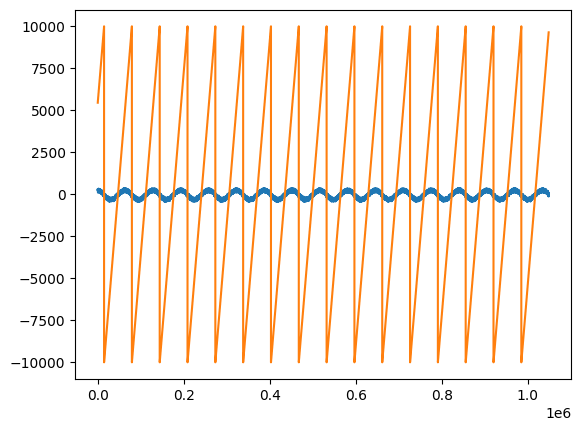

In [ ]:
%matplotlib inline
plt.plot(df_filtered.data)
plt.plot(df_filtered.encoder*2-10000)

In [ ]:
# Шаг интегрирования по encoder
step = 25
# Создание интервалов
bins = range(0, len(df_filtered) + step, step)

# Находим индексы, где происходит переход с 9999 на 0
split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]

# Добавляем начало и конец датасета
split_points = [0] + split_points.tolist() + [len(df_filtered)]

# Создаем список разделенных датафреймов с группировкой по encoder
datasets = []
for i in range(len(split_points) - 1):
    start_idx = split_points[i]
    end_idx = split_points[i+1]
    dataset_part = df_filtered.iloc[start_idx:end_idx].copy()
    dataset_part.encoder = dataset_part.encoder + 10000 * i

    # Группировка по encoder и усреднение data
    dataset_part['bin'] = pd.cut(dataset_part['encoder'], bins=bins, right=False, labels=bins[:-1])
    grouped = dataset_part.groupby('bin', observed=True)['data'].sum()
    
    datasets.append(grouped)

df_encoder = pd.concat(datasets).reset_index()
df_encoder['integrated_data'] = -1*df_encoder['data'].cumsum()/32767*2.5*(10**-5) # 2.5/32767*10**-5 - коэф. для перевода в Вольты*сек

x = df_encoder.integrated_data.index.values
y = df_encoder.integrated_data.values

# Линейная регрессия для выделения тренда
coefficients = np.polyfit(x, y, 1)  # 1 - линейный тренд
df_encoder['trend'] = np.polyval(coefficients, x)

# Детрендированные данные
df_encoder['data'] = y - df_encoder['trend']
df_encoder['deg'] = df_encoder.index/10000/step*360

df = df_encoder.reindex(columns=['deg', 'data'])

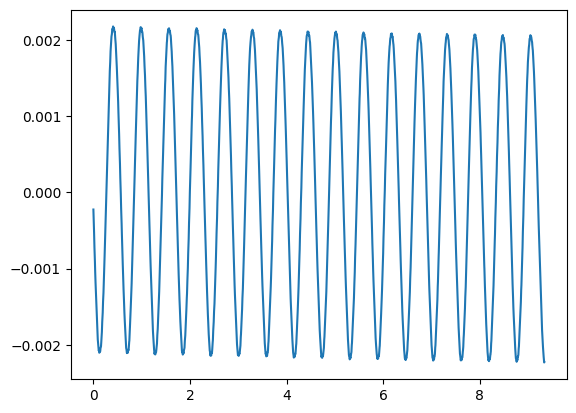

In [52]:
x = df.deg.values
y = df.data.values

# Линейная регрессия для выделения тренда
coefficients = np.polyfit(x, y, 1)  # 1 - линейный тренд
df['trend'] = np.polyval(coefficients, x)

# plt.plot(df.deg, df.trend)
plt.plot(df.deg, df.data)

In [53]:
# Локальные максимумы
local_maxima = argrelextrema(df.data.values, np.greater, order=100)[0]
# Локальные минимумы
local_minima = argrelextrema(df.data.values, np.less, order=100)[0]

print(f"Найдено локальных максимумов: {len(local_maxima)}")
print(f"Найдено локальных минимумов: {len(local_minima)}")

# Добавляем метки в DataFrame
df['is_local_max'] = False
df['is_local_min'] = False

df.loc[local_maxima, 'is_local_max'] = True
df.loc[local_minima, 'is_local_min'] = True

Найдено локальных максимумов: 16
Найдено локальных минимумов: 17


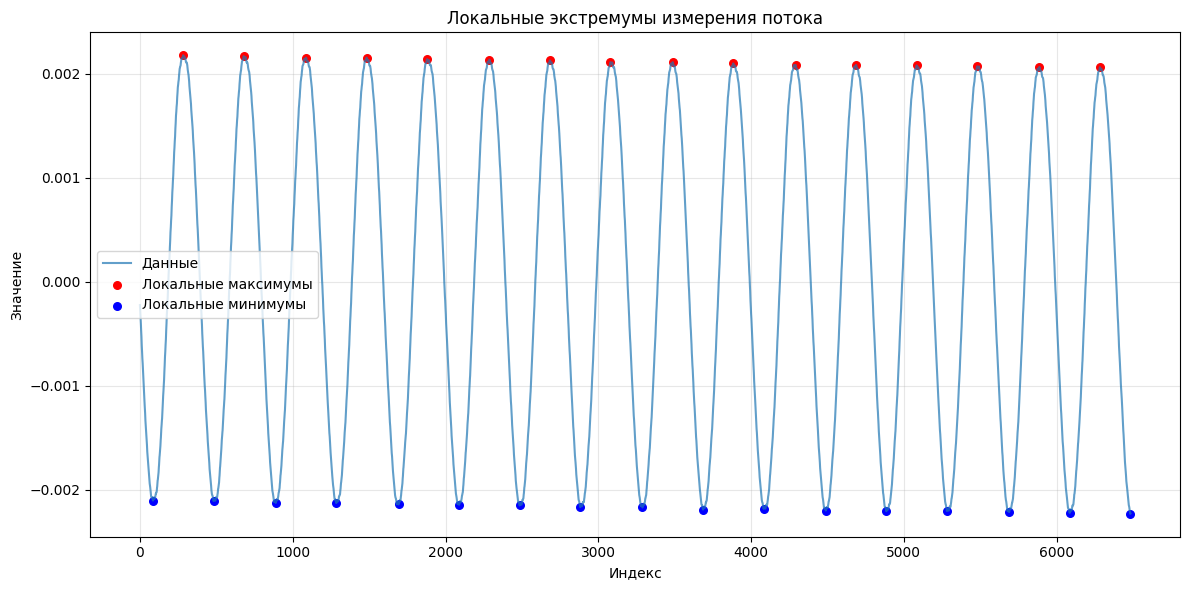

In [54]:
%matplotlib inline
data_column = 'data'

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[data_column], label='Данные', alpha=0.7)
plt.scatter(local_maxima, df.loc[local_maxima, data_column], 
           color='red', label='Локальные максимумы', s=30)
plt.scatter(local_minima, df.loc[local_minima, data_column], 
           color='blue', label='Локальные минимумы', s=30)
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('Локальные экстремумы измерения потока')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('extrema_plot.png', dpi=300)
plt.show()

In [55]:
# Извлечение экстремумов
maxima = df[df['is_local_max']]
minima = df[df['is_local_min']]

# Вычисляем средние значения
mean_max = maxima['data'].mean()
mean_min = minima['data'].mean()

# Разность средних
amplitude = (mean_max - mean_min)/2

# 3. Вычисляем погрешности
# Погрешность среднего значения максимумов
std_max = maxima['data'].std(ddof=1)
std_error_max = std_max / np.sqrt(len(maxima))

# Погрешность среднего значения минимумов
std_min = minima['data'].std(ddof=1)
std_error_min = std_min / np.sqrt(len(minima))

# Абсолютная погрешность амплитуды (по формуле погрешности разности)
absolute_error = np.sqrt(std_error_max**2 + std_error_min**2) / 2

# Относительная погрешность амплитуды
relative_error = absolute_error / amplitude * 100  # в процентах

# amps = []
amps.append([amplitude, absolute_error, relative_error, f"{amplitude:.6f} ± {absolute_error:.6f} ({relative_error:.4f}%)"])

In [77]:
amps[0][3], amps[1][3], amps[2][3]

('0.074866 ± 0.000218 (0.2909%)',
 '0.074862 ± 0.000228 (0.3040%)',
 '0.002143 ± 0.000007 (0.3182%)')

In [59]:
# Исходные данные
P_yz, dP_yz = 0.074866, 0.000218  # проекция на YZ m1
P_zx, dP_zx = 0.074862, 0.000228  # проекция на ZX m3   
P_xy, dP_xy = 0.002143, 0.000007  # проекция на XY m2

# Вычисление квадратов компонент
x_sq = (P_zx**2 + P_xy**2 - P_yz**2) / 2
y_sq = (P_xy**2 + P_yz**2 - P_zx**2) / 2
z_sq = (P_yz**2 + P_zx**2 - P_xy**2) / 2

# Полная длина вектора
M = np.sqrt((P_yz**2 + P_zx**2 + P_xy**2)/2)

# # Погрешность длины
dM_dPy = (y_sq + z_sq) / (M * P_yz)
dM_dPz = (x_sq + z_sq) / (M * P_zx)
dM_dPx = (x_sq + y_sq) / (M * P_xy)
dM = np.sqrt((dM_dPy * dP_yz)**2 + (dM_dPz * dP_zx)**2 + (dM_dPx * dP_xy)**2)

# Угол отклонения от оси Z
# θ = arctan (P_xy/((P_yz**2 + P_zx**2 – P_xy**2)**1/2]/2)

theta_rad = np.arctan(P_xy / (np.sqrt(P_yz**2 + P_zx**2 - P_xy**2)/2))
theta_deg = np.degrees(theta_rad)

# Погрешность угла
# sin_theta = np.sin(theta_rad)
# dtheta_dPy = (-y_sq * np.sqrt(z_sq)) / (L**3 * sin_theta * P_yz)
# dtheta_dPz = (x_sq * np.sqrt(z_sq) - L**2 * np.sqrt(z_sq)) / (L**3 * sin_theta * P_zx)
# dtheta_dPx = (-x_sq * np.sqrt(z_sq)) / (L**3 * sin_theta * P_xy)
# dtheta_rad = np.sqrt((dtheta_dPy * dP_yz)**2 + (dtheta_dPz * dP_zx)**2 + (dtheta_dPx * dP_xy)**2)
# dtheta_deg = np.degrees(dtheta_rad)

# Вывод результатов
print(f"Полная длина вектора: {M:.6} ± {dM:.2}")
print(f"Относительная погрешность: {(dM/M)*100:.2f}%")
print()
print(f"Угол отклонения от оси Z: {theta_deg:.4f}°") # ± {dtheta_deg:.4f}°")
# print(f"В радианах: {theta_rad:.6f} ± {dtheta_rad:.6f}")
# print(f"Относительная погрешность: {(dtheta_deg/theta_deg)*100:.4f}%")

Полная длина вектора: 0.0748793 ± 0.00032
Относительная погрешность: 0.42%

Угол отклонения от оси Z: 2.3187°


In [50]:
# Исходные данные
P_yz, dP_yz = 0.074866, 0.000218  # проекция на YZ
P_zx, dP_zx = 0.074862, 0.000228  # проекция на ZX  
P_xy, dP_xy = 0.002143, 0.000007  # проекция на XY

M = 0.074879
dM = 0.000315
Ma = 1.64

In [60]:
M_xy = 6.54e-05
M_yz = 6.53e-05
M_zx = 1.98e-06

theta_rad = np.arctan(M_xy / (np.sqrt(M_yz**2 + M_zx**2 - M_xy**2)/2))
theta_deg = np.degrees(theta_rad)
theta_deg

C:\Users\SteMart\AppData\Local\Temp\ipykernel_6692\1419691362.py:5: RuntimeWarning: invalid value encountered in sqrt
  theta_rad = np.arctan(M_xy / (np.sqrt(M_yz**2 + M_zx**2 - M_xy**2)/2))


np.float64(nan)